# Data Preprocessing of Presidential Debate 2024 (Trump vs Harris)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# load the abcnews_transcript file from the data folder
with open('../data/abcnews_transcript.txt', 'r') as file:
    data = file.read()

trumps_responses = []
kamalas_responses = []

trump_identifier = "FORMER PRESIDENT DONALD TRUMP: "
kamala_identifier = "VICE PRESIDENT KAMALA HARRIS: "

for line in data.split('\n'):
    if line.startswith(trump_identifier):
        trumps_responses.append(line[len(trump_identifier):])
    elif line.startswith(kamala_identifier):
        kamalas_responses.append(line[len(kamala_identifier):])

# load cleaned responses from the data folder for kamala kamala_responses_cleaned.txt
with open('../data/kamala_responses_cleaned.txt', 'r') as file:
    CLN_kamala_responses = file.read()

# load cleaned responses from the data folder for trump_responses_cleaned.txt
with open('../data/trump_responses_cleaned.txt', 'r') as file:
    CLN_trump_responses = file.read()



In [3]:
# Download and use the mlburnham/Political_DEBATE_base_v1.0 model from the huggingface model hub
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

gpu_id = 1

with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("mlburnham/Political_DEBATE_base_v1.0")
    model = AutoModelForSequenceClassification.from_pretrained("mlburnham/Political_DEBATE_base_v1.0").to(torch.device("cuda:"+str(gpu_id)))

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Hypotheses
hypothesis_republican = "This text expresses Republican beliefs."
hypothesis_democrat = "This text expresses Democrat beliefs."

# Function to classify each sentence
def print_political_affiliation(sentences):
    for sentence in sentences:
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(sentence, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(sentence, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Value closer to 0 means the hypothesis is more likely
        # Value closert to 1 means the hypothesis is less likely
        # If both scores are close to 1 then the sentence is neutral
        print(f"Sentence: {sentence}")
        if republican_score < 0.5:
            print(f"--> Republican belief likely ({round(republican_score,3)}).")
        if democrat_score < 0.5:
            print(f"--> Democrat belief likely ({round(democrat_score,3)}).")
        if republican_score > 0.5 and democrat_score > 0.5:
            print("--> Neutral statement.")


In [5]:
# the following sentences are examples of political beliefs 
# the first one is a republican belief, the second one is a democrat belief and the third one is a neutral belief
test_sentences = ["I believe in lower taxes and less government intervention.", 
                    "I believe in free healthcare and education for all.", 
                    "I believe in the right to bear arms and freedom of speech."]

# Run the classification
print_political_affiliation(test_sentences)  

Sentence: I believe in lower taxes and less government intervention.
--> Republican belief likely (0.0).
Sentence: I believe in free healthcare and education for all.
--> Democrat belief likely (0.002).
Sentence: I believe in the right to bear arms and freedom of speech.
--> Republican belief likely (0.102).


In [6]:
from tqdm import tqdm
# Hypotheses
hypothesis_republican = "This text expresses Republican beliefs."
hypothesis_democrat = "This text expresses Democrat beliefs."

# Function to classify each sentence
def classify_political_affiliation(sentences):
    sentence_affiliations = {}
    for sentence in tqdm(sentences):
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(sentence, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(sentence, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Enter sentence as key and scores as values
        sentence_affiliations[sentence] = []
        sentence_affiliations[sentence].append(republican_score)
        sentence_affiliations[sentence].append(democrat_score)

    return sentence_affiliations



In [7]:
trumps_affiliated_sentences = classify_political_affiliation(trumps_responses)  

100%|██████████| 74/74 [00:02<00:00, 31.08it/s]


In [8]:
harris_affiliated_sentences = classify_political_affiliation(kamalas_responses)

100%|██████████| 34/34 [00:01<00:00, 30.21it/s]


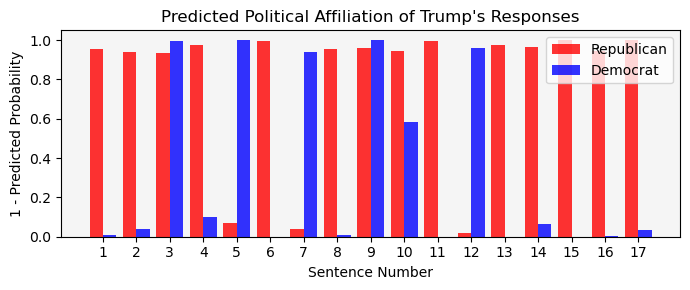

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in trumps_affiliated_sentences.items() if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
ax.set_title('Predicted Political Affiliation of Trump\'s Responses')
ax.set_xlabel('Sentence Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(np.arange(1, N + 1))
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()


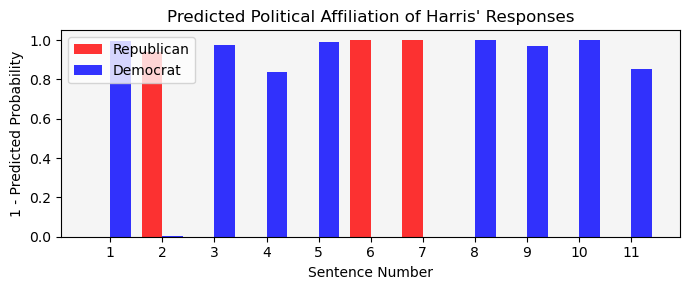

In [10]:
# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in harris_affiliated_sentences.items() if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
ax.set_title('Predicted Political Affiliation of Harris\' Responses')
ax.set_xlabel('Sentence Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(np.arange(1, N + 1))
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

In [11]:
# Print sentences in which Harris' responses are classified as Republican
# and Trump's responses are classified as Democrat

for sentence, scores in harris_affiliated_sentences.items():
    if scores[0] < 0.5:
        print(f"Kamala Harris: {sentence}")
        print(f"Scores: {scores}")
        print("Classified as Harris saying something Republican\n")

print("\n------------------------------\n")
for sentence, scores in trumps_affiliated_sentences.items():
    if scores[1] < 0.5:
        print(f"Donald Trump: {sentence}")
        print(f"Scores: {scores}")
        print("Classified as Trump saying something Democrat\n")


Kamala Harris: So, I was raised as a middle-class kid. And I am actually the only person on this stage who has a plan that is about lifting up the middle class and working people of America. I believe in the ambition, the aspirations, the dreams of the American people. And that is why I imagine and have actually a plan to build what I call an opportunity economy. Because here's the thing. We know that we have a shortage of homes and housing, and the cost of housing is too expensive for far too many people. We know that young families need support to raise their children. And I intend on extending a tax cut for those families of $6,000, which is the largest child tax credit that we have given in a long time. So that those young families can afford to buy a crib, buy a car seat, buy clothes for their children. My passion, one of them, is small businesses. I was actually -- my mother raised my sister and me but there was a woman who helped raise us. We call her our second mother. She was 

In [12]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification
import torch
from tqdm import tqdm

gpu_id = 1

# Load the tokenizer and model
with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(torch.device("cuda:"+str(gpu_id)))

# Function to classify the sentiment of each sentence
def classify_sentiment(responses):
    sentence_sentiments = {}
    # each response can be multiple sentences
    # we want to classify the sentiment of each sentence
    # and store the average sentiment of the response 
    
    # split the responses into sentences
    for response in tqdm(responses):
        sentences = response.split(".")
        sentiment_scores = []
        for sentence in sentences:
            # Tokenize the input
            inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
            
            # Get the logits
            with torch.no_grad():
                logits = model(**inputs).logits

            # Get the predicted sentiment
            sentiment = torch.argmax(logits, dim=1).item()
            #print(sentiment, sentence)                             # To check the sentiment of each sentence
            sentiment_scores.append(sentiment)
        
        # Store the average sentiment of the response along with the standard deviation
        sentence_sentiments[response] = (sum(sentiment_scores) / len(sentiment_scores), np.std(sentiment_scores))
        


    return sentence_sentiments

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
test_responses = [
    "I love this product. It's amazing! Highly recommended.",  # Positive
    "This is the worst experience I've ever had. Completely terrible.",  # Negative
    "The service was okay. Nothing special, but not bad either.",  # Neutral
    "I was impressed by the quality. The customer service was great too.",  # Positive
    "It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.",  # Mixed (partially positive and negative)
    #"Number one, I have nothing to do, as you know and as she knows better than anyone, I have nothing to do with Project 2025. That's out there. I haven't read it. I don't want to read it, purposely. I'm not going to read it. This was a group of people that got together, they came up with some ideas. I guess some good, some bad. But it makes no difference. I have nothing to do -- everybody knows I'm an open book. Everybody knows what I'm going to do. Cut taxes very substantially. And create a great economy like I did before. We had the greatest economy. We got hit with a pandemic. And the pandemic was, not since 1917 where 100 million people died has there been anything like it? We did a phenomenal job with the pandemic. We handed them over a country where the economy and where the stock market was higher than it was before the pandemic came in. Nobody's ever seen anything like it. We made ventilators for the entire world. We got gowns. We got masks. We did things that nobody thought possible. And people give me credit for rebuilding the military. They give me credit for a lot of things. But not enough credit for the great job we did with the pandemic. But the only jobs they got were bounce-back jobs. These were jobs, bounce back. And it bounced back and it went to their benefit. But I was the one that created them. They know it and so does everybody else."
]

# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

100%|██████████| 5/5 [00:00<00:00, 39.46it/s]

Response: 'I love this product. It's amazing! Highly recommended.'
Average Sentiment Score: (1.6666666666666667, 0.4714045207910317)
--------------------------------------------------
Response: 'This is the worst experience I've ever had. Completely terrible.'
Average Sentiment Score: (0.3333333333333333, 0.4714045207910317)
--------------------------------------------------
Response: 'The service was okay. Nothing special, but not bad either.'
Average Sentiment Score: (1.6666666666666667, 0.4714045207910317)
--------------------------------------------------
Response: 'I was impressed by the quality. The customer service was great too.'
Average Sentiment Score: (1.6666666666666667, 0.4714045207910317)
--------------------------------------------------
Response: 'It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.'
Average Sentiment Score: (0.75, 0.82915619758885)
--------------------------------------------------


In [14]:
# We need the indices of the responses through the entire debate
indexed_responses = {idx: line for idx, line in enumerate(data.split('\n'))}

In [15]:
trumps_sentiments = classify_sentiment(trumps_responses)
harris_sentiments = classify_sentiment(kamalas_responses)

100%|██████████| 34/34 [00:02<00:00, 12.02it/s]


In [16]:
# Print sentiments of the first 5 responses and sentences
for sentence, sentiment in trumps_sentiments.items():
    print(sentiment, sentence)



(1.6666666666666667, 0.4714045207910317) Nice to see you. Have fun.
(1.5, 0.5) Thank you.
(0.6052631578947368, 0.6299320633466223) First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the worst in our nation's h

In [17]:
indexed_sentiments = {}
for idx, response in indexed_responses.items():
    if not response:
        continue
    response = response.split(": ")[1]
    if response in trumps_sentiments:
        indexed_sentiments[idx] = "T", trumps_sentiments[response]
    elif response in harris_sentiments:
        indexed_sentiments[idx] = "H", harris_sentiments[response]


In [18]:
indexed_sentiments

{18: ('H', (1.3333333333333333, 0.4714045207910317)),
 20: ('T', (1.6666666666666667, 0.4714045207910317)),
 22: ('T', (1.5, 0.5)),
 24: ('T', (1.5, 0.5)),
 32: ('H', (1.263157894736842, 0.6359497880839249)),
 36: ('T', (0.6052631578947368, 0.6299320633466223)),
 40: ('H', (0.75, 0.82915619758885)),
 44: ('T', (1.0, 0.6324555320336759)),
 48: ('H', (0.7, 0.7810249675906655)),
 50: ('T', (1.0, 0.6793662204867574)),
 54: ('T', (0.3333333333333333, 0.4714045207910317)),
 58: ('H', (0.9, 0.7000000000000001)),
 62: ('T', (0.52, 0.64)),
 68: ('T', (1.0, 0.6324555320336759)),
 70: ('T', (0.7272727272727273, 0.4453617714151233)),
 72: ('T', (1.2608695652173914, 0.5289358721998452)),
 76: ('H', (0.42857142857142855, 0.49487165930539345)),
 78: ('H', (0.8181818181818182, 0.5749595745760689)),
 82: ('T', (0.8666666666666667, 0.6182412330330469)),
 86: ('T', (0.47368421052631576, 0.49930699897395464)),
 90: ('T', (0.6428571428571429, 0.6102859818083952)),
 94: ('H', (0.5384615384615384, 0.63432394

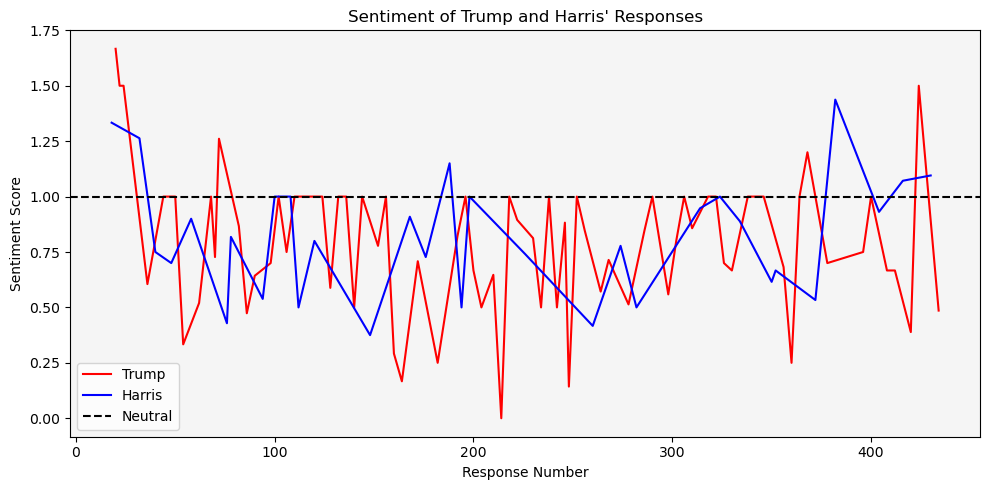

In [24]:
# Plot the indexed sentiments 
# Use a red line for Trump's responses and a blue line for Harris' responses
# Use the indexed sentiments with the idices for the x axis
# The sentiment score will be the y axis
import matplotlib.pyplot as plt

trump_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
trump_sentiments = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
harris_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]
harris_sentiments = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_sentiments, color='red', label="Trump")
ax.plot(harris_indices, harris_sentiments, color='blue', label="Harris")
# line at 1 for neutral
ax.axhline(1, color='black', linestyle='--', label='Neutral')
ax.set_title("Sentiment of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Sentiment Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()
